In [ ]:
import torch
import torch.nn as nn
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader,Dataset,random_split
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


In [ ]:
device =( "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(device)

cuda


In [ ]:

images_folder=["jpg","JPG","PNG","png","jpeg"]
dirs="/content/drive/MyDrive/dataset/Image_Brain_MIR/brain_tumor_dataset/All_yes_no/"
counter=0
X=[]
Y=[]
for imgs in os.listdir(dirs):
  if imgs.split(".")[-1] not in images_folder:
      continue

  Path=os.path.join(dirs,imgs)
  img=cv2.imread(Path)
  
  img=cv2.resize(img,(256,256))
  # img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  lowerb=np.array([0,0,37])
  upperb=np.array([179,179,179])

  mask=cv2.inRange(img_hsv, lowerb, upperb)

  result=cv2.bitwise_and(img_hsv, img_hsv,mask=mask)
  x=np.array(img)
  # y=np.array(mask)
  y_label=np.array(result)
  X.append(x)
  Y.append(y_label)
  


    


In [ ]:
len(X)

253

In [ ]:
X_tensor=torch.tensor([x for x in X],dtype=torch.float)

In [ ]:
Y_tensor=torch.tensor([x for x in Y],dtype=torch.long)

In [ ]:
X_tensor.shape

torch.Size([253, 256, 256, 3])

In [ ]:
Y_tensor.shape

torch.Size([253, 256, 256, 3])

In [ ]:
num_item=1000
color_array=np.random.choice(range(256),3*num_item).reshape(-1,3)

In [ ]:
color_array.shape

(1000, 3)

In [ ]:
num_classes=10
label_model=KMeans(n_clusters=num_classes)

In [ ]:
label_model.fit(color_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
label_model.predict(color_array[:5,:])

array([2, 6, 5, 4, 2], dtype=int32)

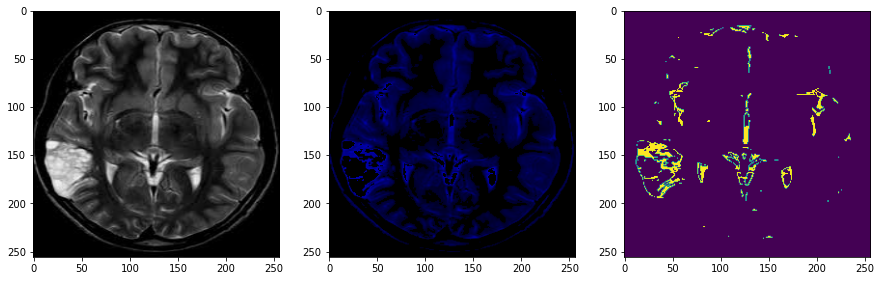

In [ ]:
label_class = label_model.predict(y_label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(x)
axes[1].imshow(y_label)
axes[2].imshow(label_class)

In [ ]:
label_class

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]], dtype=int32)

In [ ]:
class BrainMRI(Dataset):
  def __init__(self,images_dir,label_model):
    super().__init__()
    self.images_dir=images_dir
    self.image_fns=os.listdir(images_dir)
    self.label_model=label_model

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self,index):
    image_fns=self.image_fns[index]
    images_fp=os.path.join(self.images_dir,image_fns)
    image=cv2.imread(images_fp)
    X,Y=self.split_img(image)
    label_class = self.label_model.predict(Y.reshape(-1, 3)).reshape(256, 256)
    X=self.transform(X)
    label_class=torch.Tensor(label_class).long()
    return X,label_class

  def split_img(self,image):
    img=cv2.resize(image,(256,256))
    img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lowerb=np.array([0,0,37])
    upperb=np.array([179,179,179])
    mask=cv2.inRange(img_hsv, lowerb, upperb)
    result=cv2.bitwise_and(img_hsv, img_hsv,mask=mask)
    X=np.array(img)
    Y=np.array(result)
    return X,Y

  def transform(self,image):
    transform_ops=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
    return transform_ops(image)
  

In [ ]:
dataset=BrainMRI(dirs,label_model)
len(dataset)

253

In [ ]:
img,lab=dataset[0]
img.shape,lab.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [ ]:
y_label.shape

(256, 256, 3)

In [ ]:
class UNet(nn.Module):
  def __init__(self,in_channel,out_channel):
    super(UNet,self).__init__()
    self.conv1=self.contract_block(in_channel,32,7,3)
    self.conv2=self.contract_block(32,64,3,1)
    self.conv3=self.contract_block(64,128,3,1)

    self.up_sample1=self.expand_block(128,64,3,1)
    self.up_sample2=self.expand_block(64*2,32,3,1)
    self.up_sample3=self.expand_block(32*2,out_channel,3,1)

  

  def forward(self,x):
    conv1=self.conv1(x)
    conv2=self.conv2(conv1)
    conv3=self.conv3(conv2)

    upconv1=self.up_sample1(conv3)
    upconv2=self.up_sample2(torch.cat([upconv1,conv2],1))
    upconv3=self.up_sample3(torch.cat([upconv2,conv1],1))

    return upconv3


  def contract_block(self,in_channel,out_channel,kernel_size,padding):
    contract=nn.Sequential(nn.Conv2d(in_channel,out_channel,kernel_size=kernel_size,stride=1,padding=padding),
                              nn.BatchNorm2d(out_channel),
                              nn.ReLU(),
                              nn.Conv2d(out_channel,out_channel,kernel_size=kernel_size,stride=1,padding=padding),
                              nn.BatchNorm2d(out_channel),
                              nn.ReLU(),
                              nn.MaxPool2d(3,2,1))
      
      
    return contract
      
  def expand_block(self,in_channel,out_channel,kernel_size,padding):
    expand=nn.Sequential(
            nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=kernel_size,stride=1,padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=kernel_size,stride=1,padding=padding),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channel,out_channel,kernel_size=kernel_size,stride=2,padding=1,output_padding=1))
        
    return expand



In [ ]:
model=UNet(3,10).to(device)
model

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [ ]:
data_loader=DataLoader(dataset,shuffle=True,batch_size=32)

In [ ]:
img,label=next(iter(data_loader))

In [ ]:
img.shape,label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

In [ ]:
criterion=nn.CrossEntropyLoss(ignore_index=-1)
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
epochs=20

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
      X, Y = X.to(device), Y.to(device)
      Y_pred = model(X)
      loss = criterion(Y_pred, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

100%|██████████| 20/20 [03:33<00:00, 10.66s/it]


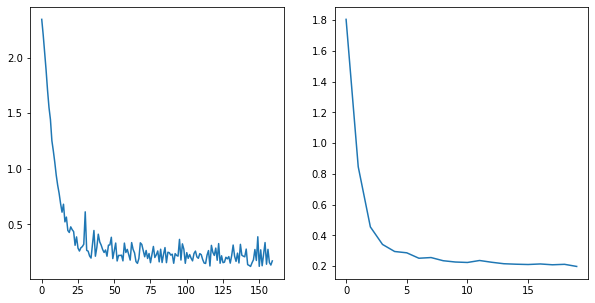

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "/content/drive/MyDrive/dataset/Image_Brain_MIR/All_yes_no_U-Net.pth"
torch.save(model.state_dict(), model_name)

In [ ]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [ ]:
test_batch_size = 8
data_loader_pred = DataLoader(dataset, batch_size=test_batch_size,shuffle=True)

In [ ]:
X, Y = next(iter(data_loader_pred))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

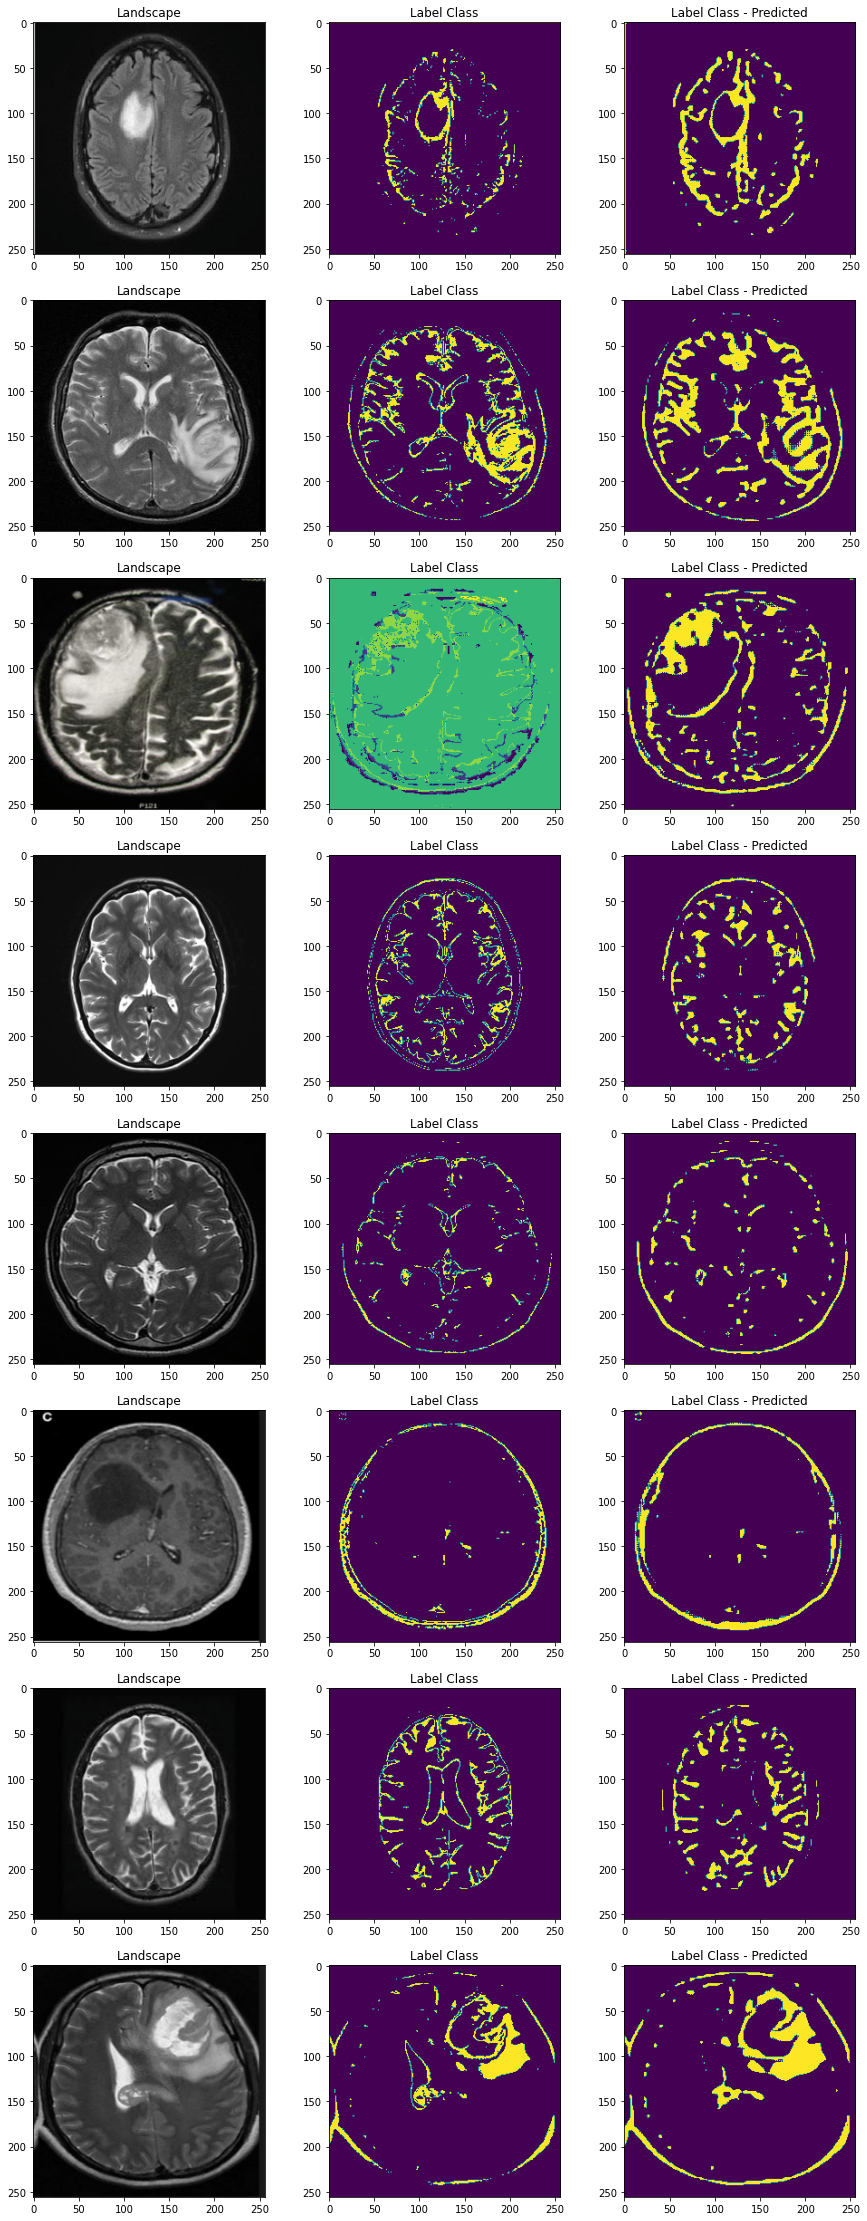

In [ ]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [ ]:
trans=transforms.Compose([transforms.Resize(256),
                          transforms.CenterCrop(224),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                      

In [ ]:
img_folder=ImageFolder(root="/content/drive/MyDrive/dataset/Image_Brain_MIR/brain_tumor_dataset/train_img",transform=trans)

In [ ]:
dirs2="/content/drive/MyDrive/dataset/Image_Brain_MIR/brain_tumor_dataset/train_img/images_convert_to_mask/"
dataset2=BrainMRI(dirs2,label_model)

In [ ]:
train_dataset=DataLoader(dataset2,batch_size=23)

In [ ]:
len(dataset2)

23

In [ ]:
X,Y=next(iter(train_dataset))
print(X.shape)

torch.Size([23, 3, 256, 256])


In [ ]:
X,Y=next(iter(train_dataset))
X,Y=X.to(device),Y.to(device)
Y_pred=model(X)
print(Y_pred.shape)
Y_pred=torch.argmax(Y_pred,dim=1)
print(Y_pred.shape)

torch.Size([23, 10, 256, 256])
torch.Size([23, 256, 256])


In [ ]:
fig, axes = plt.subplots(8, 3, figsize=(3*5, test_batch_size*5))

torch.Size([8, 3, 224, 224]) torch.Size([8])


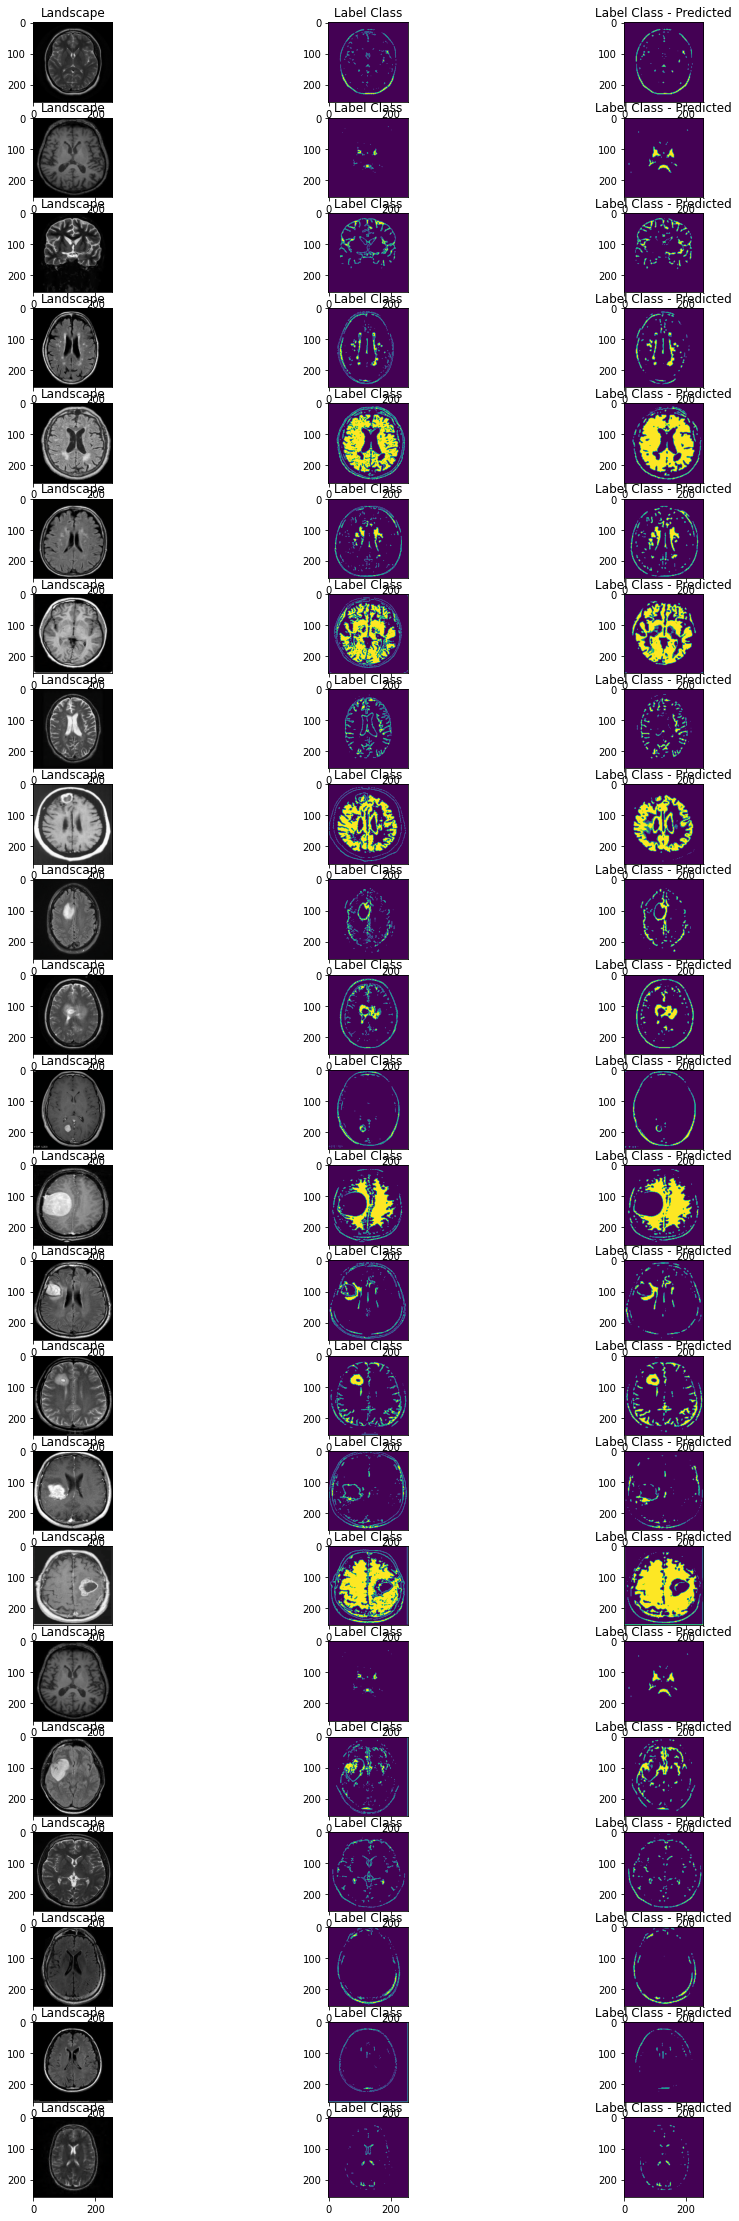

In [ ]:
fig, axes = plt.subplots(23, 3, figsize=(3*5, test_batch_size*5))
for i in range(23):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")